# Analysis of Position Rank
An anlysis of how a Consensus Position Rank is related to fantasy points between positions. The analysis is based on simulating a single team (under the assumed constraints of a snake draft) to discover how position rank of each individual position is related to other positions and their fantasy output.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

In [3]:
# Load data
df = pd.read_csv('total_ecr_stats.csv')
df = df[df['RK'] > 0]
df = df[df['FPTS'] > 0]
df.head()

,RK,TIERS,PLAYER,POS,BEST,WORST,AVG,STD_DEV,ECR_VS_ADP,POSRK,FPTS,FPTS/G,Year
0,1.0,1.0,Arian Foster,RB,1.0,4.0,1.6,0.8,0,1.0,302.1,18.9,2012.0
1,2.0,1.0,Ray Rice,RB,1.0,5.0,1.9,0.9,0,2.0,283.1,17.7,2012.0
2,3.0,1.0,LeSean McCoy,RB,2.0,4.0,3.0,0.6,0,3.0,199.3,16.6,2012.0
3,4.0,1.0,Calvin Johnson,WR,3.0,7.0,4.4,1.1,+1,1.0,342.4,21.4,2012.0
4,5.0,2.0,Aaron Rodgers,QB,4.0,12.0,6.1,1.9,-1,1.0,344.5,21.5,2012.0


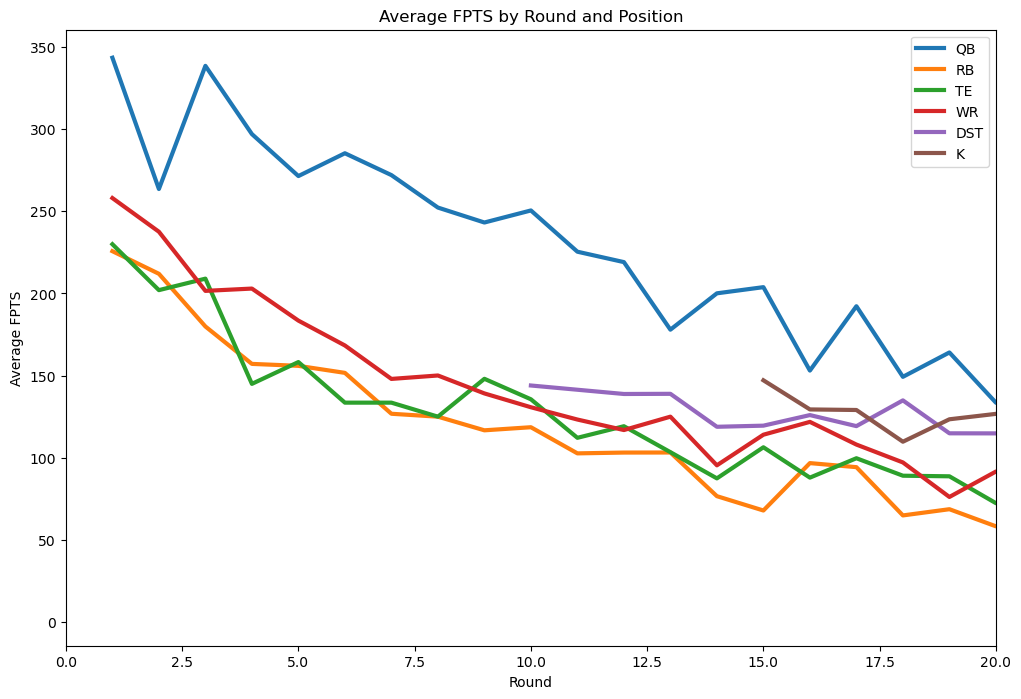

In [4]:
# New column RND, if RK <=12 then RND = 1, if RK > 12 and RK <= 24 then RND = 2.....
df['RND'] = np.ceil(df['RK']/12)

# Group by RND and Position to calculate average FPTS
df_grouped = df.groupby(['RND', 'POS']).agg({'FPTS': 'mean'}).reset_index()

# Plot average FPTS by RND and Position
fig, ax = plt.subplots(figsize=(12, 8))
for pos in df_grouped['POS'].unique():
    df_pos = df_grouped[df_grouped['POS'] == pos]
    ax.plot(df_pos['RND'], df_pos['FPTS'], label=pos, linewidth=3)
ax.set_xlabel('Round')
ax.set_ylabel('Average FPTS')
ax.set_title('Average FPTS by Round and Position')
ax.set_xlim(0, 20)
ax.legend()
plt.show()

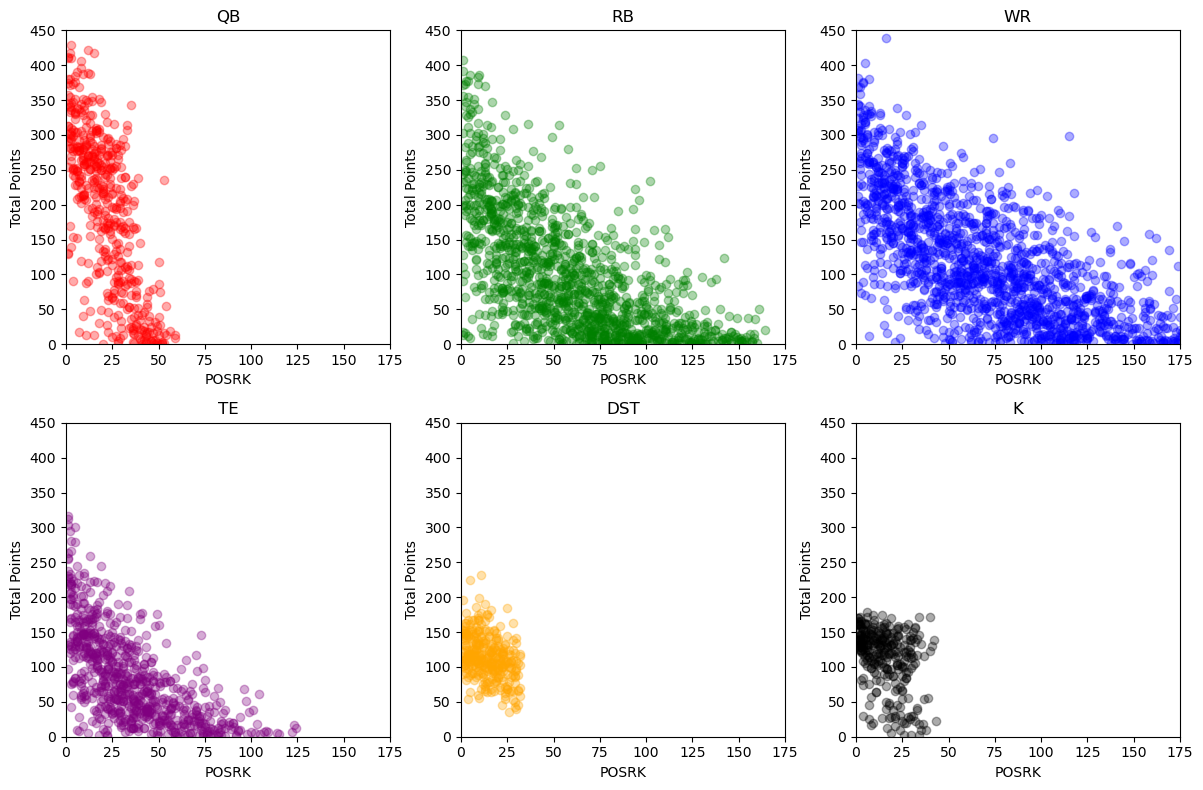

In [5]:
def plot_position(df, pos, subplot_num, color):
    data = df[df['POS'] == pos]
    plt.subplot(2, 3, subplot_num)
    plt.scatter(data['POSRK'], data['FPTS'], alpha=0.33, color=color)
    plt.title(pos)
    plt.ylabel("Total Points")
    plt.xlabel("POSRK")
    plt.ylim(0, 450)
    plt.xlim(0, 175)

plt.figure(figsize=(12,8))


positions = ['QB', 'RB', 'WR', 'TE', 'DST', 'K']
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black']
for i, (pos, color) in enumerate(zip(positions, colors), 1):
    plot_position(df, pos, i, color)

plt.tight_layout()
plt.show()

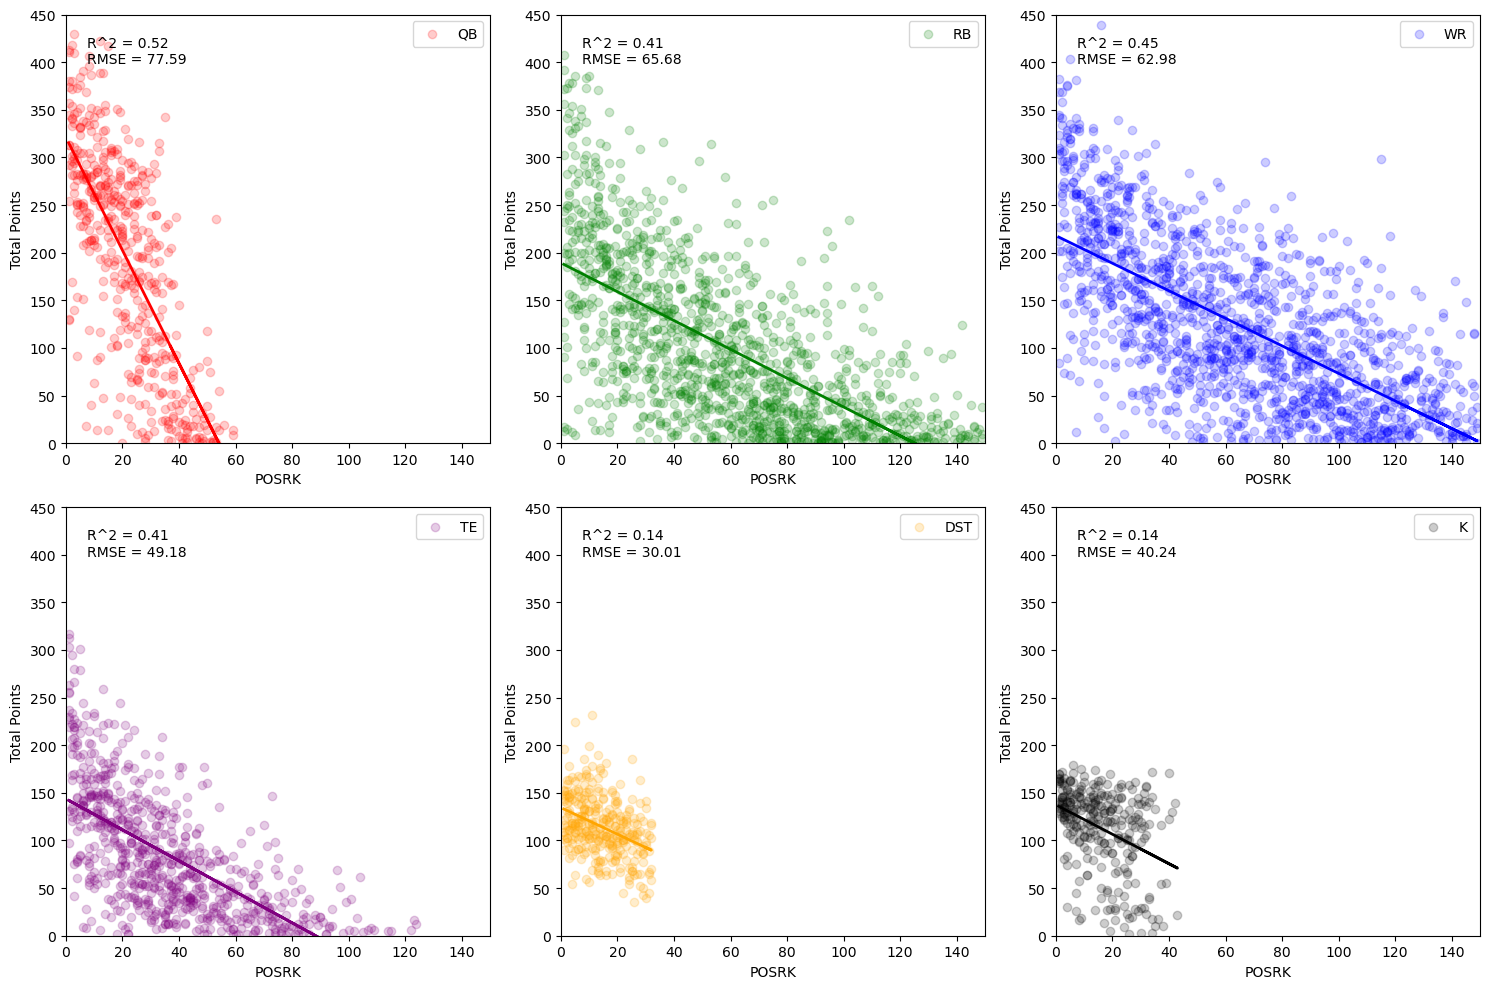

In [6]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

def analyze_position(df, pos, ax, color):
    data = df[df['POS'] == pos]
    data = data[data['POSRK'] < 150]

    X = data['POSRK'].values.reshape(-1,1)
    y = data['FPTS'].values.reshape(-1,1)

    model = LinearRegression()
    model.fit(X, y)
    pred = model.predict(X)

    r2 = model.score(X, y)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, pred))

    ax.scatter(X, y, color=color, label=pos, alpha=0.20)
    ax.plot(X, pred, color=color, linewidth=2)
    ax.text(0.05, 0.95, f'R^2 = {r2:.2f}\nRMSE = {rmse:.2f}', transform=ax.transAxes, verticalalignment='top')
    ax.set_ylabel("Total Points")
    ax.set_xlabel("POSRK")

positions = ['QB', 'RB', 'WR', 'TE', 'DST', 'K']
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black']
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs = axs.flatten() # Flatten the array of axes for easy iteration

for pos, color, ax in zip(positions, colors, axs):
    analyze_position(df, pos, ax, color)
    ax.legend()
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 450)

plt.tight_layout()
plt.show()

In [7]:
# Linear regression
from sklearn.linear_model import LinearRegression
def regression_eq(data, pos):
    positions = {"QB":2,"RB":5,"WR":5,"TE":2,"DST":1,"K":1} # Number of each position to draft for a team
    num_teams = 12
    total_positionals = {"QB":num_teams*positions["QB"], 
                         "RB":num_teams*positions["RB"],
                         "WR":num_teams*positions["WR"],
                         "TE":num_teams*positions["TE"], 
                         "DST":num_teams*positions["DST"],
                         "K":num_teams*positions["K"]} # Total number of each position to draft
    # make the data capped at the total number of each position to draft
    data = data[(data['POS'] == pos) & (data['POSRK'] <= total_positionals[pos])]
    X = data['POSRK'].values.reshape(-1,1)
    y = data['FPTS'].values.reshape(-1,1)
    model = LinearRegression()
    model.fit(X, y)
    return model

qb_model = regression_eq(df, 'QB')
rb_model = regression_eq(df, 'RB')
wr_model = regression_eq(df, 'WR')
te_model = regression_eq(df, 'TE')
dst_model = regression_eq(df, 'DST')
k_model = regression_eq(df, 'K')

In [8]:
# Simulate a team's positional draft order
import random

def random_pos(num_rounds, round, tnd):
    # tnd = total number of the position to draft
    rate = tnd/num_rounds
    lowest = max(1, (round * tnd/num_rounds) - rate)
    highest = (round * tnd/num_rounds) + rate
    return random.uniform(lowest, highest)

def pos_ranks(num_teams):
    positions = {"QB":2,"RB":5,"WR":5,"TE":2,"DST":1,"K":1} # Number of each position to draft for a team
    POS = [f"{k}" for k, v in positions.items() for i in range(v)]
    num_rounds = sum(positions.values()) # Number of total rounds for draft
    RNDS = range(1, num_rounds+1) # List of rounds
    total_positionals = {"QB":num_teams*positions["QB"], 
                         "RB":num_teams*positions["RB"],
                         "WR":num_teams*positions["WR"],
                         "TE":num_teams*positions["TE"], 
                         "DST":num_teams*positions["DST"],
                         "K":num_teams*positions["K"]} # Total number of each position to draft
    sample_RNDS = np.random.choice(RNDS, size=len(RNDS), replace=False) # Randomly shuffle RNDS
    draft_order = pd.DataFrame({"POS":POS, "RNDS":sample_RNDS}) # Concatenate the POS and RNDS lists
    # Apply random_pos function to each row
    draft_order['POSRK'] = draft_order.apply(lambda x: random_pos(num_rounds, x['RNDS'], total_positionals[x['POS']]), axis=1)
    draft_order.sort_values(by=['POS', 'POSRK'], inplace=True) # Sort RNDS within each position group
    draft_order['POS'] = pd.Categorical(draft_order['POS'], categories=['QB', 'RB', 'WR', 'TE', 'DST', 'K'], ordered=True)
    draft_order.sort_values(by='POS', inplace=True)
    draft_order['POS'] = draft_order['POS'].astype(str) + draft_order.groupby('POS').cumcount().add(1).astype(str) # Append integer to each position group
    draft_order.drop('RNDS', axis=1, inplace=True)
    
    return draft_order

pos_ranks(num_teams=12)

,POS,POSRK
1,QB1,6.875152
0,QB2,24.166768
6,RB1,7.489249
3,RB2,11.417155
4,RB3,31.870162
5,RB4,38.294964
2,RB5,57.617153
10,WR1,24.250647
11,WR2,28.462814
7,WR3,40.916260


In [9]:
# Function to calculate the total points for a team
def calculate_fpts(team):
    fpts = 0
    for i in range(len(team)):
        pos = team.iloc[i]['POS']
        rk = team.iloc[i]['POSRK']
        if pos == 'QB1':
            fpts += 1.00 * (qb_model.predict((rk).reshape(-1,1)))
        elif pos == 'QB2':
            fpts += 1.00 * (qb_model.predict((rk).reshape(-1,1)))
        elif pos == 'RB1':
            fpts += 1.00 * (rb_model.predict((rk).reshape(-1,1)))
        elif pos == 'RB2':
            fpts += 1.00 * (rb_model.predict((rk).reshape(-1,1)))
        elif pos == 'RB3':
            fpts += 1.00 * (rb_model.predict((rk).reshape(-1,1)))
        elif pos == 'RB4':
            fpts += 1.00 * (rb_model.predict((rk).reshape(-1,1)))
        elif pos == 'RB5':
            fpts += 1.00 * (rb_model.predict((rk).reshape(-1,1)))
        elif pos == 'WR1':
            fpts += 1.00 * (wr_model.predict((rk).reshape(-1,1)))
        elif pos == 'WR2':
            fpts += 1.00 * (wr_model.predict((rk).reshape(-1,1)))
        elif pos == 'WR3':
            fpts += 1.00 * (wr_model.predict((rk).reshape(-1,1)))
        elif pos == 'WR4':
            fpts += 1.00 * (wr_model.predict((rk).reshape(-1,1)))
        elif pos == 'WR5':
            fpts += 1.00 * (wr_model.predict((rk).reshape(-1,1)))
        elif pos == 'TE1':
            fpts += 1.00 * (te_model.predict((rk).reshape(-1,1)))
        elif pos == 'TE2':
            fpts += 1.00 * (te_model.predict((rk).reshape(-1,1)))
        elif pos == 'DST1':
            fpts += 1.00 * (dst_model.predict((rk).reshape(-1,1)))
        elif pos == 'K1':
            fpts += 1.00 * (k_model.predict((rk).reshape(-1,1)))
    return round(float(fpts),2)

# Generate a team
calculate_fpts(pos_ranks(num_teams=12))

2583.95

In [18]:
# Simulate teams
teams = []
for i in range(20000):
    r = pos_ranks(num_teams=12)
    teams.append([calculate_fpts(r), 
                  r[r['POS']=='QB1']['POSRK'].values[0], r[r['POS']=='QB2']['POSRK'].values[0], 
                  r[r['POS']=='RB1']['POSRK'].values[0],
                  r[r['POS']=='RB2']['POSRK'].values[0],
                  r[r['POS']=='RB3']['POSRK'].values[0],
                  r[r['POS']=='RB4']['POSRK'].values[0],
                  r[r['POS']=='RB5']['POSRK'].values[0],
                  r[r['POS']=='WR1']['POSRK'].values[0],
                  r[r['POS']=='WR2']['POSRK'].values[0],
                  r[r['POS']=='WR3']['POSRK'].values[0],
                  r[r['POS']=='WR4']['POSRK'].values[0],
                  r[r['POS']=='WR5']['POSRK'].values[0],
                  r[r['POS']=='TE1']['POSRK'].values[0], r[r['POS']=='TE2']['POSRK'].values[0], 
                  r[r['POS']=='DST1']['POSRK'].values[0], r[r['POS']=='K1']['POSRK'].values[0]])
teams = pd.DataFrame(teams, columns=['FPTS', 'QB1', 'QB2', 
                                    'RB1', 'RB2', 'RB3', 'RB4', 'RB5', 
                                    'WR1', 'WR2', 'WR3', 'WR4', 'WR5', 
                                    'TE1', 'TE2', 'DST1', 'K1'])

In [19]:
teams.head()

,FPTS,QB1,QB2,RB1,RB2,RB3,RB4,RB5,WR1,WR2,WR3,WR4,WR5,TE1,TE2,DST1,K1
0,2592.15,8.190551,21.243242,9.660291,20.455158,24.290218,35.961396,58.261056,3.790351,11.618430,27.541130,31.359468,52.020754,17.202891,25.122100,8.741767,1.132865
1,2520.96,12.026487,17.219642,12.301637,40.602061,46.033600,50.579285,62.604371,6.489009,18.000654,25.547559,35.677618,39.268494,2.881457,11.626267,1.688624,11.551092
2,2581.69,6.123008,14.331331,21.118966,28.262381,29.171814,32.650053,51.147817,4.895085,17.127775,46.278351,55.857815,62.461519,1.356842,3.777229,7.608904,8.970079
3,2618.59,7.762659,17.181790,2.356342,5.059414,14.219120,23.854226,24.780807,16.898330,27.629856,50.989834,59.484092,61.126148,13.386473,16.799692,7.334142,9.263910
4,2570.87,1.150553,21.713643,3.761967,24.555317,37.445190,38.057078,56.109077,7.930121,18.135817,27.939687,47.460239,60.194836,6.217058,17.518107,10.329828,5.340229


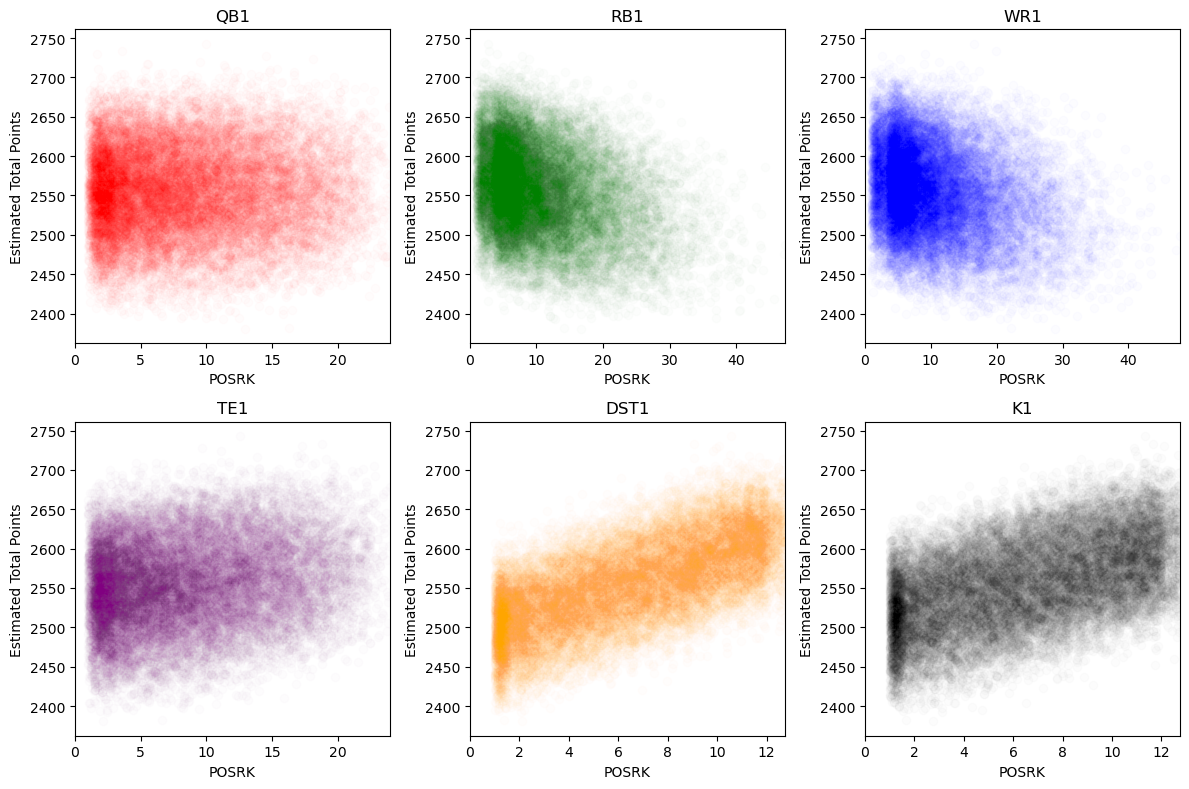

In [20]:
# Scatterplots of average posranks vs total points
def plot_scatter(teams, positions, colors):
    plt.figure(figsize=(12,8))
    for i, (pos, color) in enumerate(zip(positions, colors), 1):
        plt.subplot(2, 3, i)
        plt.scatter(teams[pos], teams['FPTS'], alpha=0.01, color=color)
        plt.xlim(0, max(teams[pos]))
        plt.title(pos)
        plt.ylabel("Estimated Total Points")
        plt.xlabel("POSRK")
        plt.tight_layout()

positions = ['QB1', 'RB1', 'WR1', 'TE1', 'DST1', 'K1']
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black']
plot_scatter(teams, positions, colors)

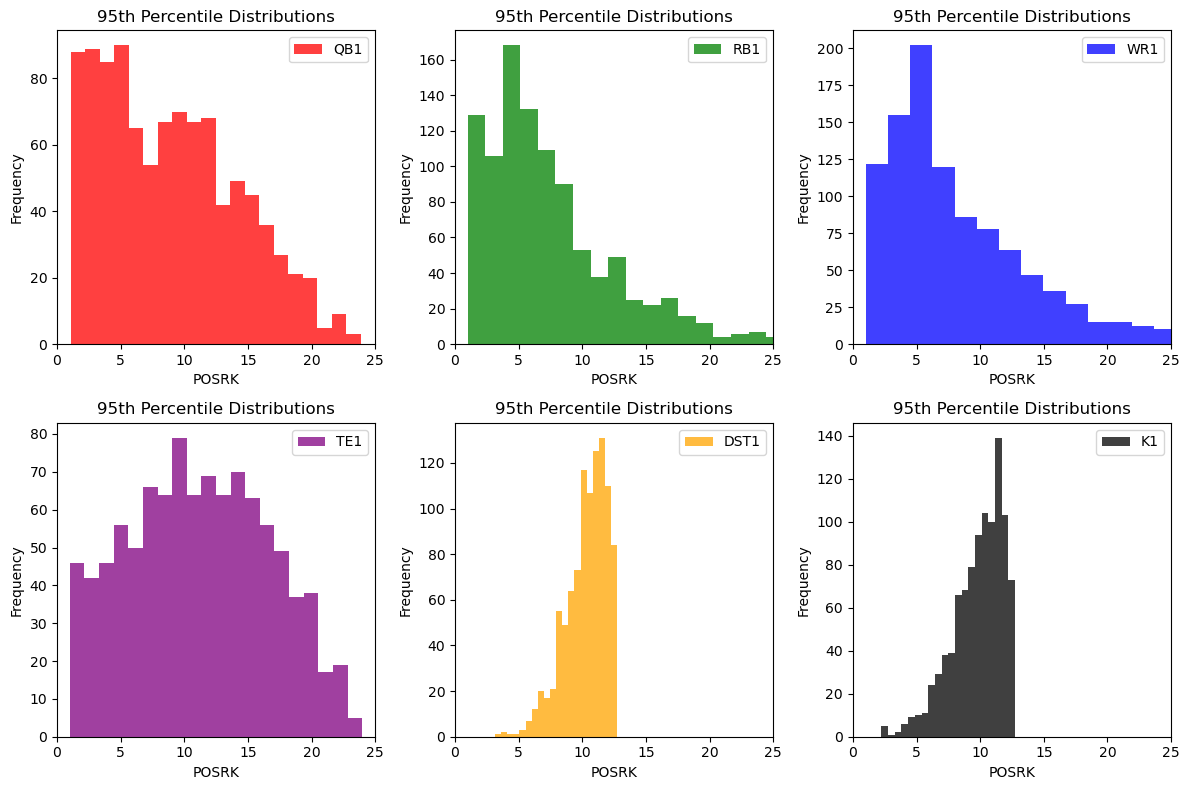

In [21]:
# Percentile of teams
quantile = teams['FPTS'].quantile(0.95)

# Create top_teams df
top_teams = teams[teams['FPTS'] > quantile]

# Histogram of positions in top teams
positions = ['QB1', 'RB1', 'WR1', 'TE1', 'DST1', 'K1']
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black']

fig, axs = plt.subplots(2, 3, figsize=(12,8))

for ax, pos, color in zip(axs.flatten(), positions, colors):
    ax.hist(top_teams[pos], bins=20, color=color, alpha=0.75, label=pos)
    ax.set_title("95th Percentile Distributions")
    ax.legend()
    ax.set_ylabel("Frequency")
    ax.set_xlabel("POSRK")
    ax.set_xlim(0, 25)

plt.tight_layout()

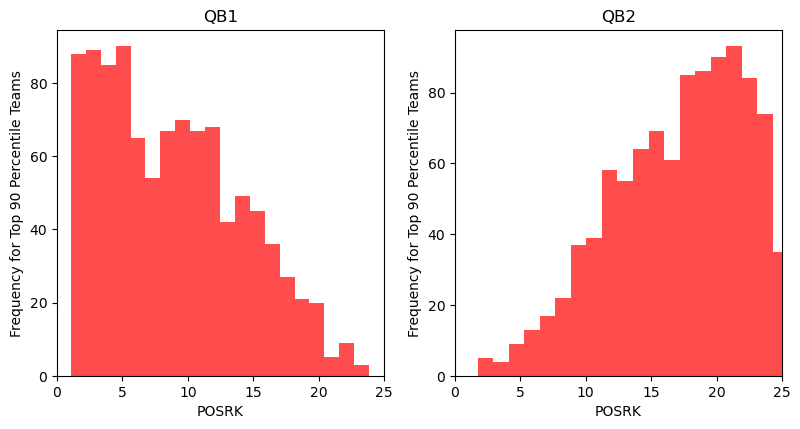

In [22]:
# Histogram of top teams RB
def plot_histogram(teams, positions, colors, xlim):
    plt.figure(figsize=(12,8))
    for i, (pos, color) in enumerate(zip(positions, colors), 1):
        plt.subplot(2, 3, i)
        plt.hist(teams[pos], color=color, bins=20, alpha=0.7)
        plt.title(pos)
        plt.ylabel("Frequency for Top 90 Percentile Teams")
        plt.xlabel("POSRK")
        plt.xlim(0, xlim)
    plt.tight_layout()
    
colors = ['red', 'red']
positions = ['QB1', 'QB2']
plot_histogram(top_teams, positions, colors, xlim=25)

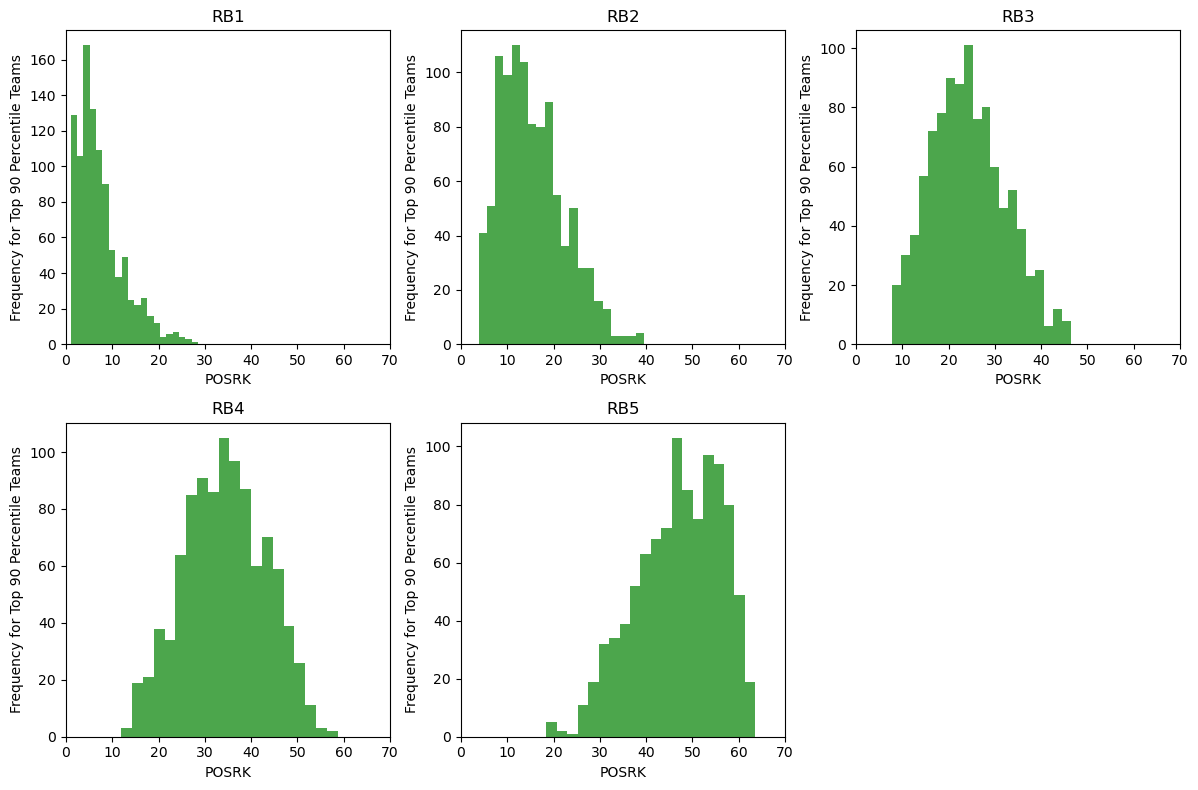

In [23]:
colors = ['green', 'green', 'green', 'green', 'green']
positions = ['RB1', 'RB2', 'RB3', 'RB4', 'RB5']
plot_histogram(top_teams, positions, colors, xlim=70)

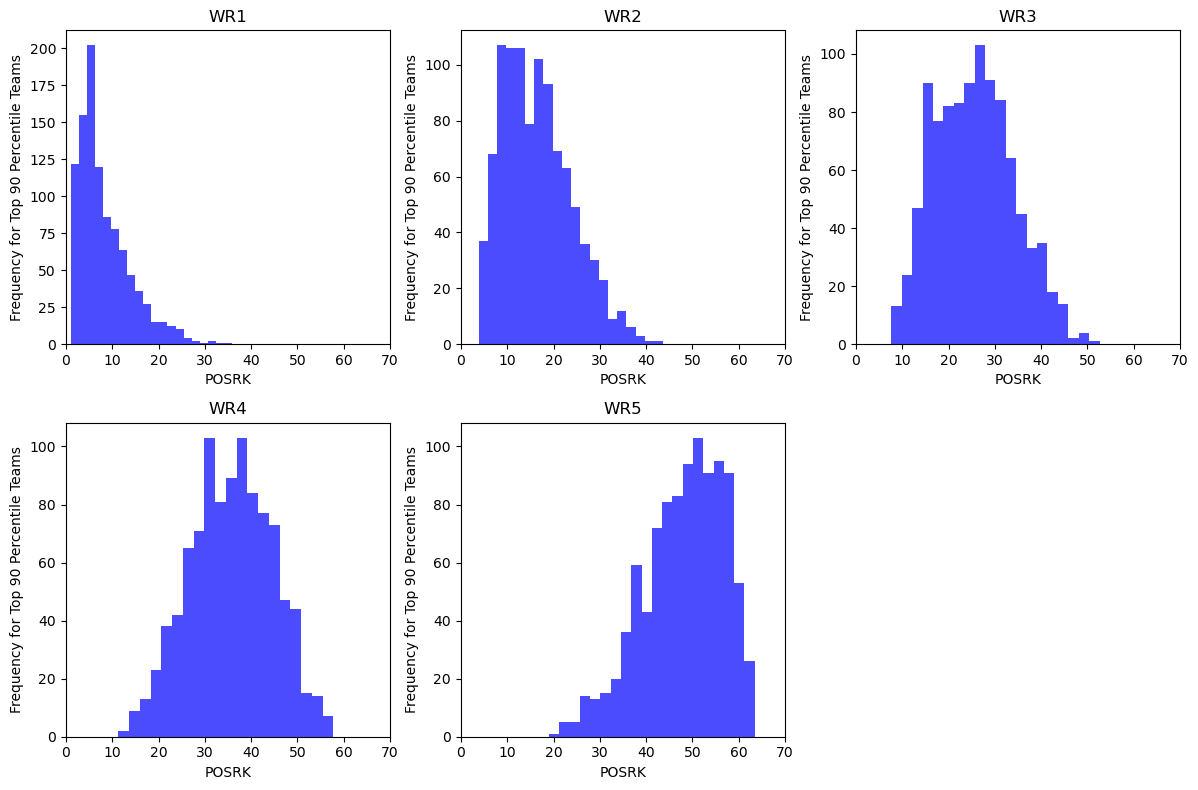

In [24]:
colors = ['blue', 'blue', 'blue', 'blue', 'blue']
positions = ['WR1', 'WR2', 'WR3', 'WR4', 'WR5']
plot_histogram(top_teams, positions, colors, xlim=70)

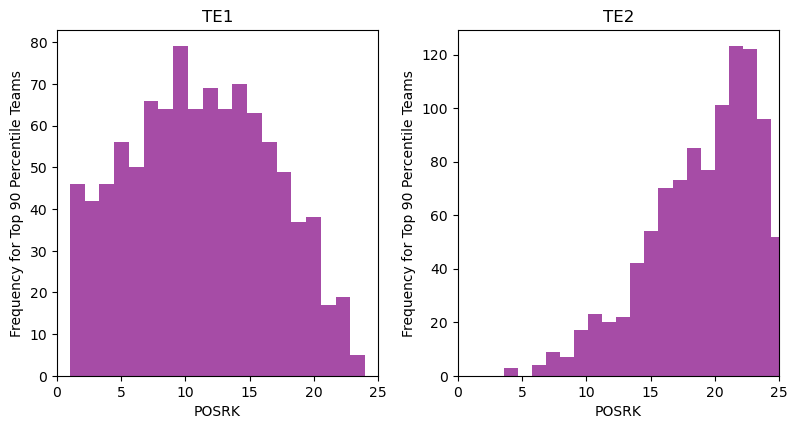

In [25]:
colors = ['purple', 'purple']
positions = ['TE1', 'TE2']
plot_histogram(top_teams, positions, colors, xlim=25)